# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


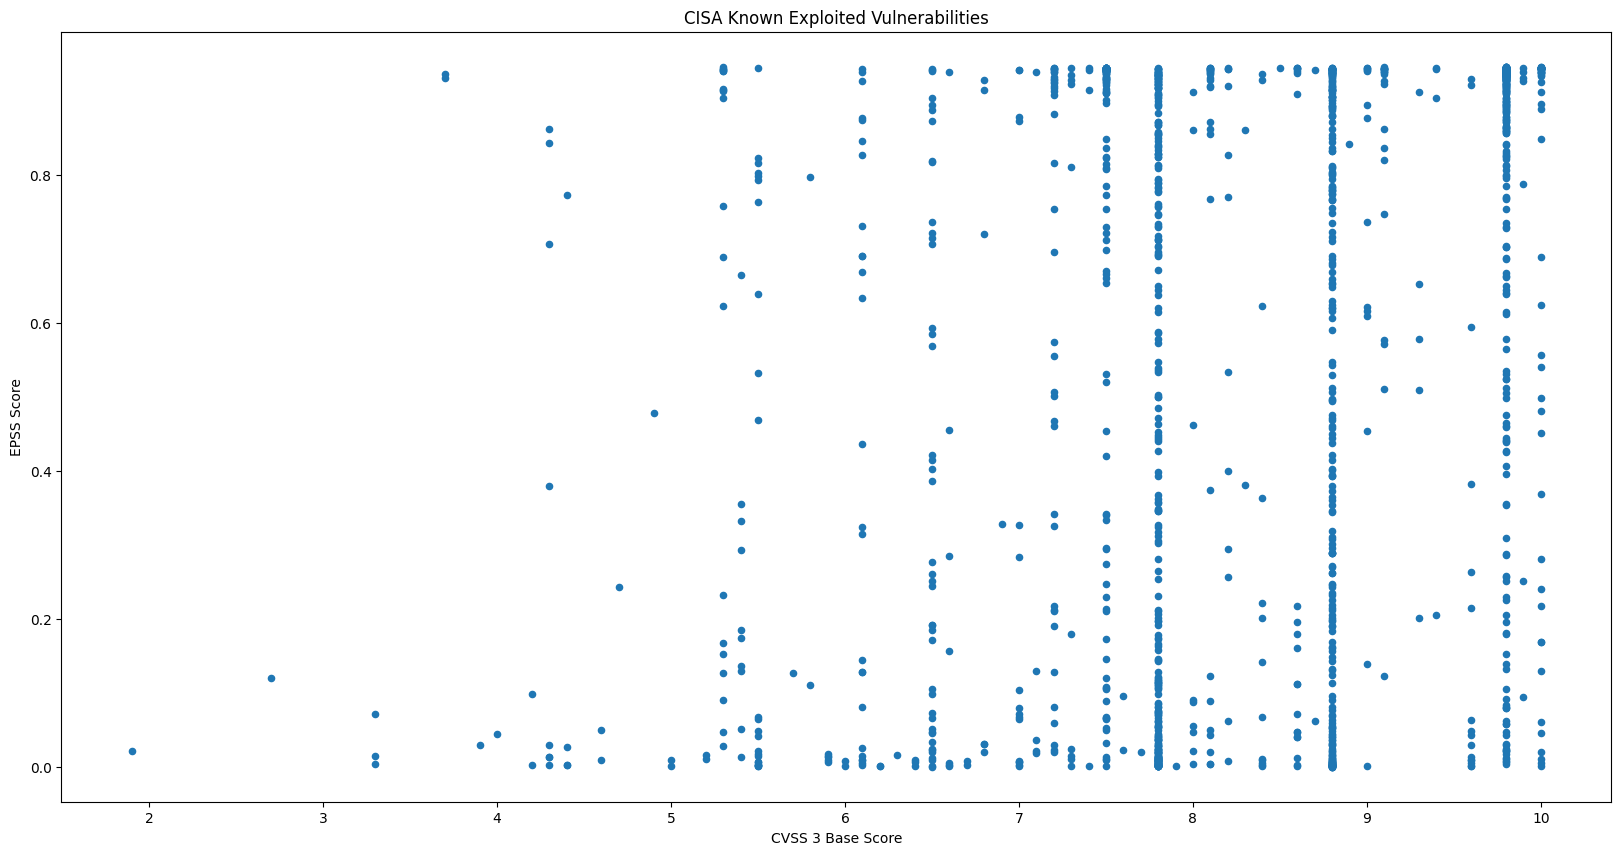

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2026-20805,5.5,0.06740,0.91017,Microsoft Windows Desktop Windows Manager cont...,2026-01-13
1,CVE-2025-8110,8.8,0.02128,0.83716,Gogs contains a path traversal vulnerability a...,2026-01-12
2,CVE-2009-0556,8.8,0.78494,0.98990,Microsoft Office PowerPoint contains a code in...,2026-01-07
3,CVE-2025-37164,10.0,0.84854,0.99309,Hewlett Packard Enterprise (HPE) OneView conta...,2026-01-07
4,CVE-2025-14847,7.5,0.51951,0.97815,MongoDB Server contains an improper handling o...,2025-12-29
5,CVE-2023-52163,8.8,0.67831,0.98529,Digiever DS-2105 Pro contains a missing author...,2025-12-22
6,CVE-2025-14733,9.8,0.40662,0.97242,WatchGuard Fireware OS iked process contains a...,2025-12-19
7,CVE-2025-59374,9.8,0.30925,0.96592,ASUS Live Update contains an embedded maliciou...,2025-12-17
8,CVE-2025-40602,6.6,0.00314,0.54087,SonicWall SMA1000 contains a missing authoriza...,2025-12-17
9,CVE-2025-20393,10.0,0.04641,0.88966,"Cisco Secure Email Gateway, Secure Email, Asyn...",2025-12-17
